# Project: Semantic Textual Similarity




### Mandatory project

https://gebakx.github.io/ihlt/sts/index.html#5

**Statement:**

- Use data set and description of task Semantic Textual Similarity in SemEval 2012.

- Implement some approaches to detect paraphrase using sentence similarity metrics.

  - Explore some lexical dimensions.
  - Explore the syntactic dimension alone.
  - Explore the combination of both previous.

- Add new components at your choice (optional)

- Compare and comment the results achieved by these approaches among them and among the official results.

- Send files to raco in IHLT STS Project before the oral presentation:

  - Jupyter notebook: sts-[Student1]-[Student2].ipynb

  - Slides: sts-[Student1]-[Student2].pdf


## Download repository

In [0]:
!git clone https://github.com/gusseppe/master_artificial_intelligence
!cp -r /content/master_artificial_intelligence/Introduction_to_Human_Language_Technology/deliverables/project/* .

## Install requirements

In [0]:
!head -n 10 requirements.txt

In [0]:
!pip install -r requirements.txt

## Third Requirements libraries

In [2]:
import tarfile
import nltk
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import csv

from nltk import CFG, ChartParser
from nltk.book import FreqDist
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from scipy.stats import pearsonr
from nltk.wsd import lesk
from nltk.corpus import wordnet_ic
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from nltk.corpus import wordnet as wn
from scipy import spatial
from sklearn.preprocessing import StandardScaler
# nltk.download() # 1. d | 2. book | 3. q
nltk.download('wordnet')
nltk.download('maxent_ne_chunker')
nltk.download('conll2000')


/home/guess/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, defaultdict


*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


[nltk_data] Downloading package wordnet to /home/guess/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/guess/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package conll2000 to /home/guess/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


True

## Download models

These models will be usefull for mapping words into real vectors. Instead of calculating cosine distance after applying some methods (lcs distance, wsd, depency trees, etc.), embeddings will take place. Models:

- Fast word2vec
- Inferset facebook


First, download Fast word2vec and unzip:

https://fasttext.cc/docs/en/english-vectors.html

Second, download Inferset (model 2) and unzip:

https://drive.google.com/file/d/1sfIlbc8C5k_CujTF7UrtW_2lvNIH-EhW/view?usp=sharing



References:

- Snippet: https://github.com/facebookresearch/InferSent/blob/master/demo.ipynb


## Load models

Once downloaded the required files, put those models in 'models_repo' folder.


1. Load Inferset model (custom model).
2. Load fasttext word2vec embedding parsing.


In [2]:
%%time

# !curl -Lo models/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip

from infersent import InferSent

model_version = 2
MODEL_PATH = f'./models_repo/infersent{model_version}.pkl'
# W2V_PATH = './models_repo/glove.840B.300d.txt' # GloVe
W2V_PATH = './models_repo/crawl-300d-2M.vec' # fastText
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}

model_senteval = InferSent(params_model)
model_senteval.load_state_dict(torch.load(MODEL_PATH))
model_senteval.set_w2v_path(W2V_PATH)
model_senteval.build_vocab_k_words(K=100000)

Vocab size : 100000
CPU times: user 4.94 s, sys: 552 ms, total: 5.5 s
Wall time: 5.6 s


# Exploratory Data Analysis

## Download train/test sets


In [0]:
url_train = 'https://www.cs.york.ac.uk/semeval-2012/task6/data/uploads/datasets/train.tgz'
url_test = 'https://www.cs.york.ac.uk/semeval-2012/task6/data/uploads/datasets/test-gold.tgz'

!wget -q $url_train
!wget -q $url_test

with tarfile.open('train.tgz', "r:gz") as tar:
  tar.extractall()
with tarfile.open('test-gold.tgz', "r:gz") as tar:
  tar.extractall()

!echo 'Training' && ls train && echo '\nTesting' && ls test-gold

Training
00-readme.txt	   STS.gs.MSRvid.txt	   STS.input.MSRvid.txt
correlation.pl	   STS.gs.SMTeuroparl.txt  STS.input.SMTeuroparl.txt
STS.gs.MSRpar.txt  STS.input.MSRpar.txt    STS.output.MSRpar.txt
\nTesting
00-readme.txt	   STS.gs.SMTeuroparl.txt	STS.input.MSRvid.txt
STS.gs.ALL.txt	   STS.gs.surprise.OnWN.txt	STS.input.SMTeuroparl.txt
STS.gs.MSRpar.txt  STS.gs.surprise.SMTnews.txt	STS.input.surprise.OnWN.txt
STS.gs.MSRvid.txt  STS.input.MSRpar.txt		STS.input.surprise.SMTnews.txt


## Read and gather metadata

Let's begin working with **MSRvid** data set

Let's load all the training data.

In [0]:
test_sents1 = pd.read_csv('test-gold/STS.input.MSRpar.txt', 
                          sep='\t',
                          quoting=csv.QUOTE_NONE, # some lines contain quotes
                          names=['sent1', 'sent2']
                          )
test_sents2 = pd.read_csv('test-gold/STS.input.MSRvid.txt', 
                          sep='\t', names=['sent1', 'sent2'])
test_sents3 = pd.read_csv('test-gold/STS.input.SMTeuroparl.txt',
                          sep='\t', names=['sent1', 'sent2'])
test_sents4 = pd.read_csv('test-gold/STS.input.surprise.OnWN.txt', 
                          sep='\t', names=['sent1', 'sent2'])
test_sents5 = pd.read_csv('test-gold/STS.input.surprise.SMTnews.txt', 
                          sep='\t', names=['sent1', 'sent2'])

In [124]:
# Training data
fnames_train = ['MSRpar', 'MSRvid', 
             'SMTeuroparl']
_train_sents = [pd.read_csv(f'train/STS.input.{f}.txt',
                           sep='\t', quoting=csv.QUOTE_NONE,
                           names=['sent1', 'sent2']) for f in fnames_train]
train_sents = pd.concat(_train_sents, axis=0, ignore_index=True)
_train_label = [pd.read_csv(f'train/STS.gs.{f}.txt',
                           names=['score']) for f in fnames_train]
train_label = pd.concat(_train_label, axis=0, ignore_index=True)
train_data = pd.concat([train_sents, train_label], axis=1)

# Testing data
fnames_test = fnames_train + ['surprise.OnWN', 'surprise.SMTnews']
_test_sents = [pd.read_csv(f'test-gold/STS.input.{f}.txt',
                           sep='\t', quoting=csv.QUOTE_NONE,
                           names=['sent1', 'sent2']) for f in fnames_test]
test_sents = pd.concat(_test_sents, axis=0, ignore_index=True)
_test_label = [pd.read_csv(f'test-gold/STS.gs.{f}.txt',
                           names=['score']) for f in fnames_test]
test_label = pd.concat(_test_label, axis=0, ignore_index=True)
test_data = pd.concat([test_sents, test_label], axis=1)


print(f' Train data set: ({len(train_data)}, {len(train_data.columns)})')
train_data.head()


 Train data set: (2234, 3)


,sent1,sent2,score
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75
2,The fines are part of failed Republican effort...,"Perry said he backs the Senate's efforts, incl...",2.80
3,"The American Anglican Council, which represent...","The American Anglican Council, which represent...",3.40
4,The tech-loaded Nasdaq composite rose 20.96 po...,The technology-laced Nasdaq Composite Index <....,2.40


In [126]:
print(f' Test data set: ({len(test_data)}, {len(test_data.columns)})')
test_data.head()


 Test data set: (3108, 3)


,sent1,sent2,score
0,The problem likely will mean corrective change...,He said the problem needs to be corrected befo...,4.4
1,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.8
2,"""It's a huge black eye,"" said publisher Arthur...","""It's a huge black eye,"" Arthur Sulzberger, th...",3.6
3,SEC Chairman William Donaldson said there is a...,"""I think there's a building confidence that th...",3.4
4,Vivendi shares closed 1.9 percent at 15.80 eur...,"In New York, Vivendi shares were 1.4 percent d...",1.4


In [0]:
# train_sents1 = pd.read_csv('train/STS.input.MSRvid.txt', 
#                            sep='\t', names=['sent1', 'sent2'])
# train_label = pd.read_csv('train/STS.gs.MSRvid.txt', names=['score'])
# train_data = pd.concat([train_sents, train_label], axis=1)

# test_sents = pd.read_csv('test-gold/STS.input.MSRvid.txt', sep='\t', names=['sent1', 'sent2'])
# test_label = pd.read_csv('test-gold/STS.gs.MSRvid.txt', names=['score'])
# test_data = pd.concat([test_sents, test_label], axis=1)


# print(f' Train data set: ({len(train_data)}, {len(train_data.columns)})')
# train_data.head()

**Check frequency of tokens**

As shown in the result we should deal with stopwords as well as punctuations.


In [127]:
sent1_tokens = train_data['sent1'].apply(nltk.word_tokenize).values
sent2_tokens = train_data['sent2'].apply(nltk.word_tokenize).values

freq_sent1 = FreqDist(np.concatenate(sent1_tokens).ravel())
freq_sent2 = FreqDist(np.concatenate(sent2_tokens).ravel())

print(f'Sentence 1:')
print(freq_sent1.most_common()[:6])

print(f'Sentence 2:')
print(freq_sent2.most_common()[:6])

Sentence 1:
[('the', 2297), ('.', 2209), (',', 1828), ('of', 1250), ('a', 1216), ('to', 1065)]
Sentence 2:
[('the', 2501), ('.', 2227), (',', 1868), ('of', 1322), ('a', 1181), ('to', 1116)]


In [0]:
train_data.dtypes

sent1     object
sent2     object
score    float64
dtype: object

## Preprocessing

- Cast sentences as type string.
- Deal with stopwords and puntuations.
- Tokenize the sentences.
- Tag each word as a Part of speech (POS).
- Lemmatize each word into its root but with sense (different than stemming).
- Extract WordNet synsets, if necessary.


**Casting**



In [0]:
# train_data[['sent1', 'sent2']] = train_data[['sent1', 'sent2']].astype(str) 
# print(train_data.dtypes)


**Stopwords and puntuations**

In [128]:
# stopwords and punctuations

def get_stopwords():
  stop_words = list(set(stopwords.words('english')))
  stop_words_2 = [w.capitalize() for w in stop_words]
  stop_words_3 = [w.upper() for w in stop_words]

  stop_words_all = stop_words + stop_words_2 + stop_words_3

  return stop_words_all

def remove_stopwords(tokens, rm_punct=False, custom_chars=None):
  
  stop_words_all = get_stopwords()
  result = [w for w in tokens if w not in stop_words_all]

  if rm_punct:
    result = [w for w in result if w not in punctuation]

  if custom_chars is not None:  # custom characters to remove
    result = [w for w in result if w not in custom_chars]

  return result

# Test
s1 = 'A man is riding a bicycle.'
remove_stopwords(nltk.word_tokenize(s1), rm_punct=True)

['man', 'riding', 'bicycle']

**POS**



In [0]:
#
# Map Treebank tag prefix to WordNet tag
#
def map_pos_wordnet(pos):
  d = {"N": wordnet.NOUN, # 'n'
       "V": wordnet.VERB, # 'v'
       "J": wordnet.ADJ, #  'a'
       "R": wordnet.ADV} #  'r'

  return d[pos[0]]

#
# Lemmatize
#
def lemmatize(pairs):
  wnl = WordNetLemmatizer()
  result = []
  for token, pos in pairs:
    if pos[0] in {'N','V', 'J', 'R'}:
      synset = wnl.lemmatize(token.lower(), 
                                     pos=map_pos_wordnet(pos))
      result.append(synset)
    else:
      result.append(token)
  return result

In [130]:
def join_tokens(tokens):
  return ' '.join(tokens)

join_tokens(['a', 'b'])

'a b'

**Embeddings**


In [0]:
def get_score_infersent(X, tokenize=True):
    eb1 = model_senteval.encode([X[0]], tokenize=tokenize)
    eb2 = model_senteval.encode([X[1]], tokenize=tokenize)

    result = 1 - spatial.distance.cosine(eb1,eb2)

    return result

**WordNet synsets**

In [0]:
#
# Get list of synsets for given list of token-pos-pairs
#
def get_wordnet_synsets(X):
    results = []
    for x in X:
        (token, pos) = x
        result = []
        
        # Try for usual PoS tags in Wordnet
        if pos[0] in {'N','V', 'J', 'R'}:
            synset = wn.synsets(token.lower(), pos=map_pos_wordnet(pos))
          
        # Else discard PoS tag and try to get some available synset
        else:
            synset = wn.synsets(token.lower())

        # Use the best found synset
        if len(synset):
            results.append(synset[0])

        # If not found, then try to cleanup the word and try again (without PoS tag)
        else:
            clean_token = token.lower().translate(str.maketrans('', '', punctuation))
            synset = wn.synsets(clean_token)

            if len(synset):
                results.append(synset[0])

            # If nothing helps, then use default synset value as neutral element and placeholder
            else:
                results.append(wn.synsets('default')[0])
        
    return results

## Feature engineering

Extract the most meaningful features from the sentences

In [0]:
cols = ['sent1_processed', 'sent2_processed']

### Synset based distance metrics

Compute multiple measures based on similarities of lemma synsets. Use *greedy* approach to align most similar lemmas using different similarity metrics:

- Path similarity
- Leacock & Chodorow (normalized)
- Wu & Palmer
- Lin

When quering synsets for single lemmas, not all synsets can be found, e.g. if lemma has PoS tag *n* and such do not exist for matching synset. For these cases, synset query is conducted without PoS tag to get at least some result. If even this does not help, then default synset is used.

Also when computing distances, an alignment of most similar synsets is done pair-wise. Mathing lemmas are then removed and do not considered in further alignment process. However, if sentences have different length, then there will be some lemmas in longer sentece left without any match in shorter sentence. In this case rest of lemmas are paired with default synset, so that their similarity is set to 0.



**Apply preprocessing steps**


In [133]:
%%time
#
# Preprocessing sentences and generating lemmas, PoS tags and synsets
# 
def preprocess_data_synsets(data):
  for col in ['sent1', 'sent2']:
    col_p = col+'_processed'
    data[col_p] = data[col].apply(nltk.word_tokenize)
    data[col_p] = data[col_p].apply(remove_stopwords, rm_punct=True)
    data[col_p] = data[col_p].apply(nltk.pos_tag)
    data[col_p] = data[col_p].apply(lemmatize)
    data[col_p] = data[col_p].apply(nltk.pos_tag)
    # data[col_p] = data[col_p].apply(join_tokens)
    # data[col_p] = data[col_p].apply(core_relationship)

    # Compute synsets for every sentence with best choices and add to dataset as extra columns
    data[col_p] = data[col_p].apply(get_wordnet_synsets)
    

# Apply preprocessing to training data
preprocess_data_synsets(train_data)  
train_data.head(2)

CPU times: user 7.52 s, sys: 104 ms, total: 7.62 s
Wall time: 7.75 s


,sent1,sent2,score,sent1_processed,sent2_processed
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00,"[Synset('beginning.n.04'), Synset('close.a.01'...","[Synset('beginning.n.04'), Synset('close.a.01'..."
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75,"[Synset('micron.n.01'), Synset('declare.v.01')...","[Synset('micron.n.01'), Synset('second.n.01'),..."


In [134]:
%%time
brown_ic = wordnet_ic.ic('ic-brown.dat')

# Lambdas for similarity measures
similarity_lin = lambda syn1, syn2: syn1.lin_similarity(syn2, ic=brown_ic)
similarity_lch = lambda syn1, syn2: syn1.lch_similarity(syn2) / syn1.lch_similarity(syn1)
similarity_wup = lambda syn1, syn2: syn1.wup_similarity(syn2)
similarity_ps = lambda syn1, syn2: syn1.path_similarity(syn2)

# Greedily find best synset pairs from two sentences and compute the average similarity
def greedy_avg_alignment_similarity(synsets, sim_f):
    
    # Use shorter list as first one
    if (len(synsets[0]) <= len(synsets[1])):
        synsets1 = synsets[0].copy()
        synsets2 = synsets[1].copy()
    else:
        synsets1 = synsets[1].copy()
        synsets2 = synsets[0].copy()
    
    # Collect best similarities comparing synsents from shorter list to longer list  
    sims = []
    for syn1 in synsets1:
        best_sim = 0
        best_syn2 = None
        
        # Find best similarity in second set
        for syn2 in synsets2:
            # Get similarity
            try:
                sim = sim_f(syn1, syn2)
            except:
                sim = 0
            
            # Check if sim = NoneType
            if not sim:
                sim = 0
            
            if sim >= best_sim:
                best_sim = sim
                best_syn2 = syn2

        # Add best pair
        sims.append(best_sim)
                
        # Remove found synset from second list
        synsets2.remove(best_syn2)
        
    # For rest of not aligned lemma pairs use default similarity of 0
    for syn2 in synsets2:
        sims.append(0)
        
    return np.mean(sims)

#
# Add different distance measuares based on synsets from WordNet
#
def add_synset_distance_metrics(data, synsets_cols):
    data['ps'] = data[synsets_cols].apply(lambda x: greedy_avg_alignment_similarity(x, similarity_ps), axis=1)
    data['lch'] = data[synsets_cols].apply(lambda x: greedy_avg_alignment_similarity(x, similarity_lch), axis=1)
    data['wup'] = data[synsets_cols].apply(lambda x: greedy_avg_alignment_similarity(x, similarity_wup), axis=1)
    data['lin'] = data[synsets_cols].apply(lambda x: greedy_avg_alignment_similarity(x, similarity_lin), axis=1)

# Append multiple synset based distances to dataframe
add_synset_distance_metrics(train_data, cols)

# Sample output
train_data.head(2)


CPU times: user 22 s, sys: 309 ms, total: 22.3 s
Wall time: 22.4 s


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00,"[Synset('beginning.n.04'), Synset('close.a.01'...","[Synset('beginning.n.04'), Synset('close.a.01'...",0.576236,0.478867,0.603125,0.441224
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75,"[Synset('micron.n.01'), Synset('declare.v.01')...","[Synset('micron.n.01'), Synset('second.n.01'),...",0.433333,0.366896,0.444444,0.280471


### Dependency Trees

**Apply preprocessing steps**

In [0]:
from nltk.parse.corenlp import CoreNLPDependencyParser
from nltk.metrics.distance import jaro_similarity, jaro_winkler_similarity

parser = CoreNLPDependencyParser(url='http://localhost:9000')

def dp_relationship(sent):

#   results = []
#   for x in X:
#     result = []

    parse = parser.raw_parse(sent)
    tree = next(parse)
    triples = list(tree.triples())
    # print(triples1)
    core_triples = list()
    for (a,b,c) in triples:
      # if b in ['nsubj']:
      core_triples.append(c)
      core_triples.append(a)
      # if b in ['nmod']:
      #   core_triples1.append(c)
      #   core_triples1.append(a)
      # elif b in ['dobj']:
      #   core_triples1.append(c)
      #   core_triples1.append(a)
    # core_triples1 = [(c, a) for (a,b,c) in triples1 if b in ['nsubj']]
    unique = []
    [unique.append(item) for item in core_triples if item not in unique]

    unique = [item for item in unique if 'V' in item[1] or 'N' in item[1] ]

    return unique


In [136]:
%%time

def preprocess_data_trees(data):
  for col in ['sent1', 'sent2']:
    data[col+'_processed'] = data[col].apply(nltk.word_tokenize)
    data[col+'_processed'] = data[col+'_processed'].apply(remove_stopwords, 
                                                          rm_punct=True)
    data[col+'_processed'] = data[col+'_processed'].apply(join_tokens)
    # data[col+'_processed'] = data[col+'_processed'].apply(nltk.pos_tag)
    data[col+'_processed'] = data[col+'_processed'].apply(dp_relationship)
    data[col+'_processed'] = data[col+'_processed'].apply(lemmatize)
    data[col+'_processed'] = data[col+'_processed'].apply(join_tokens)
    # data[col+'_processed'] = data[col+'_processed'].apply(lemmatize)
    # data[col+'_processed'] = data[col+'_processed'].apply(join_tokens)

preprocess_data_trees(train_data)
train_data.head(3)

CPU times: user 57.1 s, sys: 1.28 s, total: 58.4 s
Wall time: 5min 47s


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00,sale say source keep vivendi hop bid door see ...,sale say source keep vivendi bid door day,0.576236,0.478867,0.603125,0.441224
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75,micron declare profit year,number mark micron profit year manufacturer dram,0.433333,0.366896,0.444444,0.280471
2,The fines are part of failed Republican effort...,"Perry said he backs the Senate's efforts, incl...",2.80,part fail fine entice force effort return demo...,perry say effort senate back fine include forc...,0.423077,0.371224,0.485209,0.043715


In [137]:
%%time

depen_parsing = train_data[cols].apply(get_score_infersent, axis=1).values
depen_parsing = pd.DataFrame(np.stack(depen_parsing), columns=['dp'])
train_data = pd.concat([train_data, depen_parsing], axis=1)
train_data.head(2)

CPU times: user 4.62 ms, sys: 0 ns, total: 4.62 ms
Wall time: 5.11 ms


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00,sale say source keep vivendi hop bid door see ...,sale say source keep vivendi bid door day,0.576236,0.478867,0.603125,0.441224,0.944957
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75,micron declare profit year,number mark micron profit year manufacturer dram,0.433333,0.366896,0.444444,0.280471,0.916931


### SentEval: sentence embeddings

This function yields a score from  a pretrained model, based on word embedding.




In [0]:
#!conda install pytorch torchvision cpuonly -c pytorch

In [138]:
def preprocess_data_sentevel(data):
  for col in ['sent1', 'sent2']:
    data[col+'_processed'] = data[col].apply(nltk.word_tokenize)
    data[col+'_processed'] = data[col+'_processed'].apply(remove_stopwords, 
                                                          rm_punct=True)
    data[col+'_processed'] = data[col+'_processed'].apply(nltk.pos_tag)
    data[col+'_processed'] = data[col+'_processed'].apply(lemmatize)
    data[col+'_processed'] = data[col+'_processed'].apply(join_tokens)

preprocess_data_sentevel(train_data)
train_data.head(3)

,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00,source close sale say vivendi keep door open b...,source close sale say vivendi keep door open b...,0.576236,0.478867,0.603125,0.441224,0.944957
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75,micron declare first quarterly profit three year,micron 's number also mark first quarterly pro...,0.433333,0.366896,0.444444,0.280471,0.916931
2,The fines are part of failed Republican effort...,"Perry said he backs the Senate's efforts, incl...",2.80,fine part fail republican effort force entice ...,perry say back senate 's effort include fine f...,0.423077,0.371224,0.485209,0.043715,0.939007


In [139]:
%%time

infer_feat = train_data[cols].apply(get_score_infersent, axis=1)
infer_feat = pd.DataFrame(np.stack(infer_feat), columns=['infer'])
train_data = pd.concat([train_data, infer_feat], axis=1)
train_data.head(2)


CPU times: user 9min 48s, sys: 299 ms, total: 9min 48s
Wall time: 9min 48s


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp,infer
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00,source close sale say vivendi keep door open b...,source close sale say vivendi keep door open b...,0.576236,0.478867,0.603125,0.441224,0.944957,0.958609
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75,micron declare first quarterly profit three year,micron 's number also mark first quarterly pro...,0.433333,0.366896,0.444444,0.280471,0.916931,0.946287


### Overlapping

Count how many words appears from one sentence to the other.




In [0]:
def preprocess_count_overlap(data):
  for col in ['sent1', 'sent2']:
    data[col+'_processed'] = data[col].apply(nltk.word_tokenize)
    data[col+'_processed'] = data[col+'_processed'].apply(remove_stopwords, 
                                                          rm_punct=True)
    data[col+'_processed'] = data[col+'_processed'].apply(nltk.pos_tag)
    data[col+'_processed'] = data[col+'_processed'].apply(lemmatize)
    data[col+'_processed'] = data[col+'_processed'].apply(join_tokens)


preprocess_count_overlap(train_data)


def count_overlap(X):
  words1 = X[0].strip().split()
  words2 = X[1].strip().split()

  counter = 0
  for w in words1:
    counter += words2.count(w)

  score = 2*counter / (len(words1) + len(words2))

  return score


In [213]:
%%time

overlap_feat = train_data[cols].apply(count_overlap, axis=1)
overlap_feat = pd.DataFrame(np.stack(overlap_feat), columns=['over'])
train_data = pd.concat([train_data, overlap_feat], axis=1)
train_data.head(2)


CPU times: user 140 ms, sys: 0 ns, total: 140 ms
Wall time: 183 ms


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp,infer,over
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00,source close sale say vivendi keep door open b...,source close sale say vivendi keep door open b...,0.576236,0.478867,0.603125,0.441224,0.944957,0.958609,0.642857
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75,micron declare first quarterly profit three year,micron 's number also mark first quarterly pro...,0.433333,0.366896,0.444444,0.280471,0.916931,0.946287,0.631579


# Modeling

Try a baseline model with the final features: basically the join of the scores (fom dependency tree, wds, lcs, etc).







In [140]:
train_data.head(2)

,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp,infer
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00,source close sale say vivendi keep door open b...,source close sale say vivendi keep door open b...,0.576236,0.478867,0.603125,0.441224,0.944957,0.958609
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75,micron declare first quarterly profit three year,micron 's number also mark first quarterly pro...,0.433333,0.366896,0.444444,0.280471,0.916931,0.946287


In [214]:
label = 'score'
features = [col for col in train_data.columns if col not in ['sent1',
                                                             'sent2',
                                                             'sent1_processed',
                                                             'sent2_processed', label]]
X = train_data[features].copy()
y = train_data[label].copy()
X.head()

,ps,lch,wup,lin,dp,infer,over
0,0.576236,0.478867,0.603125,0.441224,0.944957,0.958609,0.642857
1,0.433333,0.366896,0.444444,0.280471,0.916931,0.946287,0.631579
2,0.423077,0.371224,0.485209,0.043715,0.939007,0.938343,0.500000
3,0.622222,0.355331,0.638889,0.333333,0.950514,0.964189,0.733333
4,0.621759,0.593266,0.727564,0.465101,0.879717,0.913712,0.260870


Save training features and label

In [0]:
X_y = pd.concat([X, y], axis=1)
X_y.to_csv('train_features.csv', index=False)

Scaling all the features with mean 0 and  variance 1



In [216]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X) # This scaler will be used for testing stage too

X_scaled = scaler.transform(X)
X_scaled

array([[ 0.50869582,  0.08256956,  0.27500424, ...,  0.07579499,
         0.36778079,  0.32854469],
       [-0.16624555, -0.55401826, -0.59293359, ..., -0.71572413,
        -0.00341259,  0.28332649],
       [-0.21468735, -0.52941227, -0.36996169, ..., -0.09224227,
        -0.2427314 , -0.24421923],
       ...,
       [ 2.51016403,  0.20271383,  2.44579842, ...,  1.63037194,
         1.61466474,  1.7604545 ],
       [ 0.18625694,  0.24130234,  0.31719527, ...,  0.20388678,
         0.693956  ,  0.61492665],
       [-2.04891601, -1.89756609, -2.51533142, ..., -0.69555023,
        -0.73282645, -1.10336511]])

In [217]:
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

test_size = 0.2
seed = 42
X_train, X_val, y_train, y_val = train_test_split(
                X_scaled, y, test_size=test_size, random_state=seed)

X_train

array([[-1.75372378, -1.35589997, -1.96835965, ..., -0.36029553,
        -0.58159939, -2.24889296],
       [-0.73021555, -1.24995855, -0.77317668, ..., -0.23910232,
        -0.38560733,  0.04216273],
       [ 0.2376524 ,  0.57317172,  0.11737002, ...,  0.31304535,
        -0.17631919,  0.04216273],
       ...,
       [ 0.11114144,  1.45922535,  1.4473579 , ...,  0.4640028 ,
         0.31281524, -0.9124438 ],
       [-0.36866308,  0.47087765, -0.21068585, ..., -1.14612644,
        -0.99700832, -0.9124438 ],
       [ 1.05690996,  1.70906983,  0.62255921, ...,  0.18719753,
         0.05026374,  0.42400535]])

In [0]:
# !pip install xgboost

In [299]:
%%time

from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor

from xgboost import XGBRegressor

# params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 1,
#           'learning_rate': 0.01, 'loss': 'ls'}
params = {'n_estimators': [500], 'seed':[seed]}
base_estimator = XGBRegressor()
# model = XGBRegressor()
# for k, v in model.get_params().items():
#     if k not in list(params.keys()):
#         params[k] = [v]


# scoring = 'r2'
# num_folds = 5

# kfold = KFold(n_splits=num_folds, random_state=seed)
# grid_search_t = GridSearchCV(model, params, n_jobs=-1,
#                              verbose=1, cv=kfold, 
#                              return_train_score=True,
#                              scoring=scoring)
base_estimator.fit(X_train, y_train)
base_estimator.score(X_val, y_val)

# mean = grid_search_t.cv_results_['mean_test_score'][0]
# std = grid_search_t.cv_results_['std_test_score'][0]

# name = 'GradientBoostingRegressor'
# d = {'name': name, 'mean': round(mean, 3),
#                  'std': round(std, 3)}

# #Base model

# estimator = grid_search_t.best_estimator_

# d
# clf.fit(X_train, y_train)
# mse = mean_squared_error(y_test, clf.predict(X_test))
# print("MSE: %.4f" % mse)


/home/guess/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[06:32:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 130 ms, sys: 12 ms, total: 142 ms
Wall time: 206 ms


0.6386506949842549

Train with all data

In [300]:
base_estimator.fit(X_scaled, y.values)
base_estimator

[06:32:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

## Tuning

Search the best hyperparameters

In [0]:
# !pip install hyperopt, hpsklearn

In [226]:
%%time

from hpsklearn import HyperoptEstimator, xgboost_regression, any_regressor, any_preprocessing
from hyperopt import tpe

# estim = HyperoptEstimator(regressor=xgboost_regression('my_clf'),
estim = HyperoptEstimator(regressor=xgboost_regression('my_clf'),                          
#                           preprocessing=[],
                          algo=tpe.suggest,
                          max_evals=80,
                          trial_timeout=300)

estim.fit( X_train, y_train.values )
print(estim.score(X_val, y_val.values))
print(estim.best_model())

[04:00:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
100%|██████████| 1/1 [00:00<00:00,  1.80it/s, best loss: 3.7893839838847754]
[04:00:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
100%|██████████| 1/1 [00:04<00:00,  4.11s/it, best loss: 0.36548779030293377]
[04:00:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
100%|██████████| 1/1 [00:01<00:00,  2.00s/it, best loss: 0.36548779030293377]
[04:00:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
100%|██████████| 1/1 [00:04<00:00,  4.42s/it, best loss: 0.29757540822355544]
[04:00:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
100%|██████████| 1/1 [00:01<00:00,  1.07s/it, best los

In [227]:
best_model_final = estim.best_model()['learner']
best_model_final

XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.691256899739684, colsample_bynode=1,
             colsample_bytree=0.9885013962238178, gamma=8.632535322717437e-06,
             importance_type='gain', learning_rate=0.009988285015986373,
             max_delta_step=0, max_depth=6, min_child_weight=2, missing=nan,
             n_estimators=1400, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0.9986344039069726,
             reg_lambda=2.754875724586894, scale_pos_weight=1, seed=4,
             silent=None, subsample=0.9323234655182262, verbosity=1)

Once we decide the best model, we need to retrain  the model with all the training set.

In [228]:
best_model_final.fit(X_scaled, y.values)
best_model_final            

[04:03:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.691256899739684, colsample_bynode=1,
             colsample_bytree=0.9885013962238178, gamma=8.632535322717437e-06,
             importance_type='gain', learning_rate=0.009988285015986373,
             max_delta_step=0, max_depth=6, min_child_weight=2, missing=nan,
             n_estimators=1400, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0.9986344039069726,
             reg_lambda=2.754875724586894, scale_pos_weight=1, seed=4,
             silent=None, subsample=0.9323234655182262, verbosity=1)

## Testing

We need to apply all the preprocessing and feature engineering steps to the test data set.

**Synset based metrics**

In [150]:
# Preprocess test data
preprocess_data_synsets(test_data) 
test_data.head(5)

,sent1,sent2,score,sent1_processed,sent2_processed
0,The problem likely will mean corrective change...,He said the problem needs to be corrected befo...,4.4,"[Synset('problem.n.01'), Synset('likely.a.01')...","[Synset('say.n.01'), Synset('problem.n.01'), S..."
1,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.8,"[Synset('default.n.01'), Synset('national_asso...","[Synset('wide.a.01'), Synset('standard.n.01'),..."
2,"""It's a huge black eye,"" said publisher Arthur...","""It's a huge black eye,"" Arthur Sulzberger, th...",3.6,"[Synset('default.n.01'), Synset('second.n.01')...","[Synset('default.n.01'), Synset('second.n.01')..."
3,SEC Chairman William Donaldson said there is a...,"""I think there's a building confidence that th...",3.4,"[Synset('second.n.01'), Synset('president.n.04...","[Synset('default.n.01'), Synset('think.v.01'),..."
4,Vivendi shares closed 1.9 percent at 15.80 eur...,"In New York, Vivendi shares were 1.4 percent d...",1.4,"[Synset('default.n.01'), Synset('share.n.01'),...","[Synset('new.a.01'), Synset('york.n.01'), Syns..."


In [151]:
# Append multiple synset based distances to dataframe
add_synset_distance_metrics(test_data, cols)
test_data.head(2)

,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin
0,The problem likely will mean corrective change...,He said the problem needs to be corrected befo...,4.4,"[Synset('problem.n.01'), Synset('likely.a.01')...","[Synset('say.n.01'), Synset('problem.n.01'), S...",0.285233,0.347540,0.340741,0.231831
1,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.8,"[Synset('default.n.01'), Synset('national_asso...","[Synset('wide.a.01'), Synset('standard.n.01'),...",0.506706,0.588826,0.582735,0.392431


**Dependency trees**

In [155]:
%%time

preprocess_data_trees(test_data)
test_data.head(3)

CPU times: user 1min 27s, sys: 2.15 s, total: 1min 29s
Wall time: 7min 50s


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin
0,The problem likely will mean corrective change...,He said the problem needs to be corrected befo...,4.4,problem mean change start fleet shuttle fly,correct say need problem clear fleet space shu...,0.285233,0.347540,0.340741,0.231831
1,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.8,index nasdaq composite,poor index,0.506706,0.588826,0.582735,0.392431
2,"""It's a huge black eye,"" said publisher Arthur...","""It's a huge black eye,"" Arthur Sulzberger, th...",3.6,eye say jr. publisher arthur ochs sulzberger p...,say eye publisher newspaper arthur sulzberger ...,0.572329,0.505012,0.626161,0.469726


In [156]:
%%time

depen_parsing_test = test_data[cols].apply(get_score_infersent, axis=1).values
depen_parsing_test = pd.DataFrame(np.stack(depen_parsing_test), columns=['dp'])
test_data = pd.concat([test_data, depen_parsing_test], axis=1)
test_data.head(2)

CPU times: user 8min 17s, sys: 379 ms, total: 8min 18s
Wall time: 8min 21s


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp
0,The problem likely will mean corrective change...,He said the problem needs to be corrected befo...,4.4,problem mean change start fleet shuttle fly,correct say need problem clear fleet space shu...,0.285233,0.347540,0.340741,0.231831,0.963686
1,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.8,index nasdaq composite,poor index,0.506706,0.588826,0.582735,0.392431,0.952877


**SentEval word embedding**


In [157]:
%%time

# Preprocess data
preprocess_data_sentevel(test_data)

infer_feat_test = test_data[cols].apply(get_score_infersent, axis=1)
infer_feat_test = pd.DataFrame(np.stack(infer_feat_test), columns=['infer'])
test_data = pd.concat([test_data, infer_feat_test], axis=1)
test_data.head(2)                                                

CPU times: user 9min 31s, sys: 371 ms, total: 9min 31s
Wall time: 9min 33s


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp,infer
0,The problem likely will mean corrective change...,He said the problem needs to be corrected befo...,4.4,problem likely mean corrective change shuttle ...,say problem need correct space shuttle fleet c...,0.285233,0.347540,0.340741,0.231831,0.963686,0.964584
1,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.8,technology-laced nasdaq composite index .ixic ...,broad standard poor 's 500 index .spx inch 3 p...,0.506706,0.588826,0.582735,0.392431,0.952877,0.946450


### Overlap words

In [229]:
preprocess_count_overlap(test_data)
test_data.head(3)

,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp,infer
0,The problem likely will mean corrective change...,He said the problem needs to be corrected befo...,4.4,problem likely mean corrective change shuttle ...,say problem need correct space shuttle fleet c...,0.285233,0.347540,0.340741,0.231831,0.963686,0.964584
1,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.8,technology-laced nasdaq composite index .ixic ...,broad standard poor 's 500 index .spx inch 3 p...,0.506706,0.588826,0.582735,0.392431,0.952877,0.946450
2,"""It's a huge black eye,"" said publisher Arthur...","""It's a huge black eye,"" Arthur Sulzberger, th...",3.6,`` 's huge black eye '' say publisher arthur o...,`` 's huge black eye '' arthur sulzberger news...,0.572329,0.505012,0.626161,0.469726,0.947358,0.950543


In [230]:
%%time

overlap_feat_test = test_data[cols].apply(count_overlap, axis=1)
overlap_feat_test = pd.DataFrame(np.stack(overlap_feat_test), columns=['over'])
test_data = pd.concat([test_data, overlap_feat_test], axis=1)
test_data.head(2)


CPU times: user 135 ms, sys: 0 ns, total: 135 ms
Wall time: 145 ms


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp,infer,over
0,The problem likely will mean corrective change...,He said the problem needs to be corrected befo...,4.4,problem likely mean corrective change shuttle ...,say problem need correct space shuttle fleet c...,0.285233,0.347540,0.340741,0.231831,0.963686,0.964584,0.444444
1,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.8,technology-laced nasdaq composite index .ixic ...,broad standard poor 's 500 index .spx inch 3 p...,0.506706,0.588826,0.582735,0.392431,0.952877,0.946450,0.333333


### Splitting


In [231]:
X_test = test_data[features].copy()
y_test = test_data[label].copy()
print(len(X_test))
X_test.head()

3108


,ps,lch,wup,lin,dp,infer,over
0,0.285233,0.347540,0.340741,0.231831,0.963686,0.964584,0.444444
1,0.506706,0.588826,0.582735,0.392431,0.952877,0.946450,0.333333
2,0.572329,0.505012,0.626161,0.469726,0.947358,0.950543,0.709677
3,0.485281,0.553779,0.538273,0.481043,0.940341,0.942599,0.526316
4,0.293447,0.365735,0.379464,0.334849,0.903658,0.927247,0.421053


Save testing features

In [0]:
X_y_test = pd.concat([X_test, y_test], axis=1)
X_y_test.to_csv('test_features.csv', index=False)

**Scaling**

In [233]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[-8.65733289e-01, -6.64059222e-01, -1.16016356e+00, ...,
         6.04752103e-01,  5.47792399e-01, -4.66960754e-01],
       [ 1.80299655e-01,  7.07711348e-01,  1.63474364e-01, ...,
         2.99493957e-01,  1.49645800e-03, -9.12443805e-01],
       [ 4.90241796e-01,  2.31210719e-01,  4.01006641e-01, ...,
         1.43619283e-01,  1.24786475e-01,  5.96450398e-01],
       ...,
       [-1.92666468e+00, -1.82480364e+00, -2.40997130e+00, ...,
        -1.14722906e+00, -2.38331356e+00, -2.24889296e+00],
       [-1.96338101e+00, -1.84546970e+00, -2.38916184e+00, ...,
        -2.02937080e+00, -6.79979668e-01,  1.09546723e-01],
       [ 2.39454548e-01, -2.22079986e+00,  3.32498432e-01, ...,
         6.97716334e-01,  9.07819216e-01,  4.21627318e-02]])

With tunning

In [234]:
y_pred = best_model_final.predict(X_test_scaled)


print(f'Pearson correlation: {pearsonr(y_test.values, y_pred)[0]}')

Pearson correlation: 0.7157993941663809


Without tuning

In [301]:
y_pred = base_estimator.predict(X_test_scaled)


print(f'Pearson correlation: {pearsonr(y_test.values, y_pred)[0]}')

Pearson correlation: 0.7099004567694918


### Feature importance


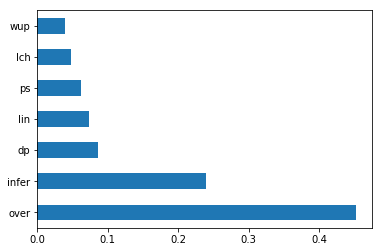

In [249]:
import matplotlib.pyplot as plt

(pd.Series(best_model_final.feature_importances_, index=X.columns)
   .nlargest(10)
   .plot(kind='barh')) 
plt.show()

# AutoML

Try out several models taking into advantage metalearning approach, which is the feature learning space learnt from differents types of datasets. 

Reference:

- Efficient and Robust Automated Machine Learning, Feurer et al., Advances in Neural Information Processing Systems 28 (NIPS 2015).


In [0]:
# !sudo apt-get install build-essential swig
# !pip install auto-sklearn

In [0]:
# !pip install deap update_checker tqdm stopit tpot

Read training features

In [3]:
train_load = pd.read_csv('train_features.csv')
print(len(train_load))
X_load_train = train_load.loc[:, train_load.columns != 'score']
y_load_train = train_load['score']

scaler2 = StandardScaler()
scaler2.fit(X_load_train) # This scaler will be used for testing stage too
X_load_train_scaled = scaler2.transform(X_load_train)

X_load_train.head()

2234


,ps,lch,wup,lin,dp,infer,over
0,0.576236,0.478867,0.603125,0.441224,0.944957,0.958609,0.642857
1,0.433333,0.366896,0.444444,0.280471,0.916931,0.946287,0.631579
2,0.423077,0.371224,0.485209,0.043715,0.939007,0.938343,0.500000
3,0.622222,0.355331,0.638889,0.333333,0.950514,0.964189,0.733333
4,0.621759,0.593266,0.727564,0.465101,0.879717,0.913712,0.260870


Read testing features

In [4]:
test_load = pd.read_csv('test_features.csv')
print(len(test_load))
X_load_test = test_load.loc[:, test_load.columns != 'score']
y_load_test = test_load['score']

# X_load_test_reduced = X_load_test[[c for c in list(X_load_test.columns) 
#                           if c not in feats_to_remove]]
X_load_test_scaled = scaler2.transform(X_load_test)

X_load_test.head()

3108


,ps,lch,wup,lin,dp,infer,over
0,0.285233,0.347540,0.340741,0.231831,0.963686,0.964584,0.444444
1,0.506706,0.588826,0.582735,0.392431,0.952877,0.946450,0.333333
2,0.572329,0.505012,0.626161,0.469726,0.947358,0.950543,0.709677
3,0.485281,0.553779,0.538273,0.481043,0.940341,0.942599,0.526316
4,0.293447,0.365735,0.379464,0.334849,0.903658,0.927247,0.421053


auto-sklearn

In [4]:
%%time

import autosklearn.regression

# automl = autosklearn.regression.AutoSklearnRegressor()
feature_types = (['numerical'] * X_load_train_scaled.shape[1])
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=60*5,
    per_run_time_limit=30,
    seed=1
    # tmp_folder='/tmp/autosklearn_regression_example_tmp',
    # output_folder='/tmp/autosklearn_regression_example_out',
)

automl.fit(X_load_train_scaled, y_load_train.values,
               feat_type=feature_types)
# y_hat = automl.predict(X_test)

# best_model_final.fit(X_scaled, y.values)
automl            

/home/guess/anaconda3/lib/python3.7/site-packages/pyparsing.py:2725: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/guess/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/guess/anaconda3/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-12-09 07:12:03,638:AutoMLSMBO(1)::4d8d747d0aed32d359a9bfa9a91f80a7] Could not find meta-data directory /home/guess/anaconda3/lib/python3.7/site-packages/autosklearn/metalearning/files/r2_regression_dense
[WARNING] [2019-12-09 07:12:03,655:EnsembleBuilder(1):4d8d747d0aed32d359a9bfa9a91f80a7] No models better than random - using Dummy Score!
[WARNING] [2019-12-09 07:12:03,672:EnsembleBuilder(1):4d8d747d0aed32d359a9bfa9a91f80a7] No models better than random - using Dummy Score!


/home/guess/anaconda3/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/guess/anaconda3/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/guess/anaconda3/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/guess/anaconda3/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/guess/anaconda3/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/guess/anaconda3/lib/python3.7/site-packages/autosklear

[WARNING] [2019-12-09 07:16:54,085:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-12-09 07:16:54,085:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-12-09 07:16:57,681:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-12-09 07:16:57,681:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
1
['/tmp/autosklearn_tmp_13397_6668/.auto-sklearn/ensembles/1.0000000000.ensemble', '/tmp/autosklearn_tmp_13397_6668/.auto-sklearn/ensembles/1.0000000001.ensemble', '/tmp/autosklearn_tmp_13397_6668/.auto-sklearn/ensembles/1.0000000002.ensemble', '/tmp/autosklearn_tmp_13397_6668/.auto-sklearn/ensembles/1.0000000003.ensemble', '/tmp/autosklearn_tmp_13397_6668/.auto-sklearn/ensemb

AutoSklearnRegressor(delete_output_folder_after_terminate=True,
           delete_tmp_folder_after_terminate=True,
           disable_evaluator_output=False, ensemble_memory_limit=1024,
           ensemble_nbest=50, ensemble_size=50, exclude_estimators=None,
           exclude_preprocessors=None, get_smac_object_callback=None,
           include_estimators=None, include_preprocessors=None,
           initial_configurations_via_metalearning=25, logging_config=None,
           metadata_directory=None, ml_memory_limit=3072, n_jobs=None,
           output_folder=None, per_run_time_limit=30,
           resampling_strategy='holdout',
           resampling_strategy_arguments=None, seed=1, shared_mode=False,
           smac_scenario_args=None, time_left_for_this_task=300,
           tmp_folder=None)

Tpot

In [5]:
%%time

from tpot import TPOTRegressor

tpot = TPOTRegressor(generations=20, population_size=50, 
                     verbosity=1, n_jobs=-1, random_state=42)
tpot.fit(X_load_train_scaled, y_load_train.values)


Best pipeline: RandomForestRegressor(AdaBoostRegressor(ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.9000000000000001, min_samples_leaf=3, min_samples_split=11, n_estimators=100), learning_rate=0.1, loss=linear, n_estimators=100), bootstrap=False, max_features=0.05, min_samples_leaf=2, min_samples_split=4, n_estimators=100)
CPU times: user 2min 23s, sys: 9.13 s, total: 2min 32s
Wall time: 31min 44s


TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
              disable_update_check=False, early_stop=None, generations=20,
              max_eval_time_mins=5, max_time_mins=None, memory=None,
              mutation_rate=0.9, n_jobs=-1, offspring_size=None,
              periodic_checkpoint_folder=None, population_size=50,
              random_state=42, scoring=None, subsample=1.0, template=None,
              use_dask=False, verbosity=1, warm_start=False)

Auto sklearn

In [5]:
y_pred2 = automl.predict(X_load_test_scaled)

print(f'Pearson correlation: {pearsonr(y_load_test.values, y_pred2)[0]}')

Pearson correlation: 0.7256968527053161


Tpot

In [6]:
y_pred2 = tpot.predict(X_load_test_scaled)

print(f'Pearson correlation: {pearsonr(y_load_test.values, y_pred2)[0]}')

Pearson correlation: 0.719207068032175


Base

In [195]:
y_pred2 = automl.predict(X_load_test_scaled)

print(f'Pearson correlation: {pearsonr(y_test.values, y_pred2)[0]}')

1
['/tmp/autosklearn_tmp_12651_1979/.auto-sklearn/ensembles/1.0000000000.ensemble', '/tmp/autosklearn_tmp_12651_1979/.auto-sklearn/ensembles/1.0000000001.ensemble', '/tmp/autosklearn_tmp_12651_1979/.auto-sklearn/ensembles/1.0000000002.ensemble', '/tmp/autosklearn_tmp_12651_1979/.auto-sklearn/ensembles/1.0000000003.ensemble', '/tmp/autosklearn_tmp_12651_1979/.auto-sklearn/ensembles/1.0000000004.ensemble', '/tmp/autosklearn_tmp_12651_1979/.auto-sklearn/ensembles/1.0000000005.ensemble', '/tmp/autosklearn_tmp_12651_1979/.auto-sklearn/ensembles/1.0000000006.ensemble', '/tmp/autosklearn_tmp_12651_1979/.auto-sklearn/ensembles/1.0000000007.ensemble', '/tmp/autosklearn_tmp_12651_1979/.auto-sklearn/ensembles/1.0000000008.ensemble', '/tmp/autosklearn_tmp_12651_1979/.auto-sklearn/ensembles/1.0000000009.ensemble', '/tmp/autosklearn_tmp_12651_1979/.auto-sklearn/ensembles/1.0000000010.ensemble', '/tmp/autosklearn_tmp_12651_1979/.auto-sklearn/ensembles/1.0000000011.ensemble', '/tmp/autosklearn_tmp_126

## Feature selection

We have to selection those features that are not correlated and more important. Similarly, remove those highly correlated and less important.



In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

f = plt.figure(figsize=(5, 5))
corr = X_load_train.corr(method='pearson')

plt.title('Numerical features')
sns.heatmap(corr, annot=True, cmap="YlGnBu")
plt.show();

<Figure size 500x500 with 2 Axes>

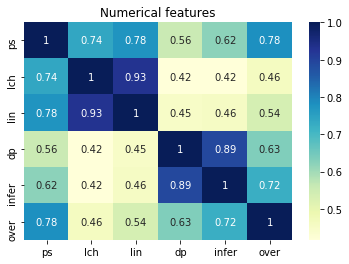

In [6]:
feats_to_remove = ['wup']
X_train_reduced = X_load_train[[c for c in list(X_load_train.columns) 
                          if c not in feats_to_remove]]
corr = X_train_reduced.corr(method='pearson')

plt.title('Numerical features')
sns.heatmap(corr, annot=True, cmap="YlGnBu")
plt.show();

In [15]:
import autosklearn.regression



feature_types = (['numerical'] * X_train_reduced.values.shape[1])
automl2 = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=60*2,
    per_run_time_limit=30,
)

X_load_train_reduced_scaled = X_load_train_scaled[:, 1:]

automl2.fit(X_load_train_reduced_scaled, y_load_train.values )



/home/guess/anaconda3/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-12-09 08:20:53,142:AutoMLSMBO(1)::e0922da2dfe015cc6daac63c8b39004b] Could not find meta-data directory /home/guess/anaconda3/lib/python3.7/site-packages/autosklearn/metalearning/files/r2_regression_dense
[WARNING] [2019-12-09 08:20:53,159:EnsembleBuilder(1):e0922da2dfe015cc6daac63c8b39004b] No models better than random - using Dummy Score!
[WARNING] [2019-12-09 08:20:53,167:EnsembleBuilder(1):e0922da2dfe015cc6daac63c8b39004b] No models better than random - using Dummy Score!


/home/guess/anaconda3/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/guess/anaconda3/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/guess/anaconda3/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/guess/anaconda3/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/guess/anaconda3/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/guess/anaconda3/lib/python3.7/site-packages/autosklear

1
['/tmp/autosklearn_tmp_18877_8424/.auto-sklearn/ensembles/1.0000000000.ensemble', '/tmp/autosklearn_tmp_18877_8424/.auto-sklearn/ensembles/1.0000000001.ensemble', '/tmp/autosklearn_tmp_18877_8424/.auto-sklearn/ensembles/1.0000000002.ensemble', '/tmp/autosklearn_tmp_18877_8424/.auto-sklearn/ensembles/1.0000000003.ensemble', '/tmp/autosklearn_tmp_18877_8424/.auto-sklearn/ensembles/1.0000000004.ensemble', '/tmp/autosklearn_tmp_18877_8424/.auto-sklearn/ensembles/1.0000000005.ensemble', '/tmp/autosklearn_tmp_18877_8424/.auto-sklearn/ensembles/1.0000000006.ensemble', '/tmp/autosklearn_tmp_18877_8424/.auto-sklearn/ensembles/1.0000000007.ensemble', '/tmp/autosklearn_tmp_18877_8424/.auto-sklearn/ensembles/1.0000000008.ensemble']
[08:22:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:22:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


AutoSklearnRegressor(delete_output_folder_after_terminate=True,
           delete_tmp_folder_after_terminate=True,
           disable_evaluator_output=False, ensemble_memory_limit=1024,
           ensemble_nbest=50, ensemble_size=50, exclude_estimators=None,
           exclude_preprocessors=None, get_smac_object_callback=None,
           include_estimators=None, include_preprocessors=None,
           initial_configurations_via_metalearning=25, logging_config=None,
           metadata_directory=None, ml_memory_limit=3072, n_jobs=None,
           output_folder=None, per_run_time_limit=30,
           resampling_strategy='holdout',
           resampling_strategy_arguments=None, seed=1, shared_mode=False,
           smac_scenario_args=None, time_left_for_this_task=120,
           tmp_folder=None)

In [16]:
X_load_test_reduced_scaled = X_load_test_scaled[:, 1:]
y_pred2 = automl2.predict(X_load_test_reduced_scaled)


print(f'Pearson correlation: {pearsonr(y_load_test.values, y_pred2)[0]}')

Pearson correlation: 0.7181710128701657


In [262]:
y_pred2 = automl2.predict(X_load_test_reduced_scaled)


print(f'Pearson correlation: {pearsonr(y_load_test.values, y_pred2)[0]}')

Pearson correlation: 0.722289444024046


# Conclusions





